In [ ]:
!pip3 install torch

In [ ]:
!pip install datasets

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models
from torch.utils.data import DataLoader
from datasets import load_dataset

In [ ]:
# Load dataset
train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Dataset class to apply transformations
class AlzheimerMRIDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Load image and label
        item = self.hf_dataset[idx]
        image = item["image"]
        label = item["label"]
        image = self.transform(image)  # Apply transformation

        return image, label

# Convert to PyTorch datasets
train_data = AlzheimerMRIDataset(train_dataset, transform)
test_data = AlzheimerMRIDataset(test_dataset, transform)

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [ ]:
# Set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Adjust the output layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

epochs = 15
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training accuracy
    train_accuracy = correct / total
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Test
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    epoch_labels = []
    epoch_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:  # Test data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            epoch_labels.extend(labels.cpu().numpy())
            epoch_preds.extend(predicted.cpu().numpy())

    # Calculate accuracy and loss
    test_accuracy = test_correct / test_total
    epoch_test_loss = test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/15, Train Loss: 0.6415, Train Accuracy: 0.7271
Test Loss: 0.6612, Test Accuracy: 0.7453
Epoch 2/15, Train Loss: 0.1826, Train Accuracy: 0.9320
Test Loss: 0.3922, Test Accuracy: 0.8375
Epoch 3/15, Train Loss: 0.0702, Train Accuracy: 0.9734
Test Loss: 0.6387, Test Accuracy: 0.8156
Epoch 4/15, Train Loss: 0.0382, Train Accuracy: 0.9863
Test Loss: 0.4695, Test Accuracy: 0.8430
Epoch 5/15, Train Loss: 0.0503, Train Accuracy: 0.9834
Test Loss: 0.7530, Test Accuracy: 0.8086
Epoch 6/15, Train Loss: 0.0710, Train Accuracy: 0.9771
Test Loss: 1.2954, Test Accuracy: 0.6547
Epoch 7/15, Train Loss: 0.0568, Train Accuracy: 0.9816
Test Loss: 0.4633, Test Accuracy: 0.8695
Epoch 8/15, Train Loss: 0.0268, Train Accuracy: 0.9916
Test Loss: 0.2417, Test Accuracy: 0.9164
Epoch 9/15, Train Loss: 0.0205, Train Accuracy: 0.9939
Test Loss: 0.3212, Test Accuracy: 0.9047
Epoch 10/15, Train Loss: 0.0271, Train Accuracy: 0.9918
Test Loss: 0.1106, Test Accuracy: 0.9609
Epoch 11/15, Train Loss: 0.0402, Train 

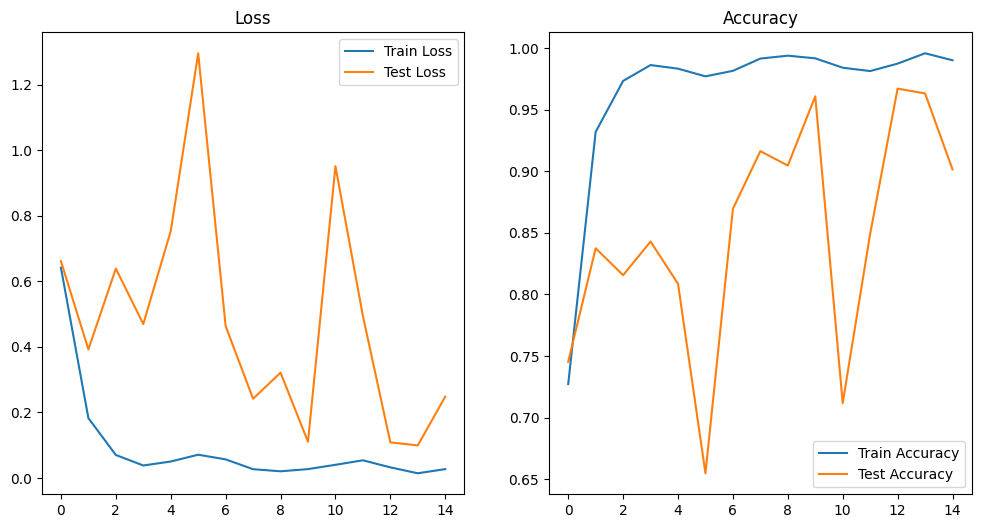

F1 Score: 0.9096
Accuracy: 0.9016


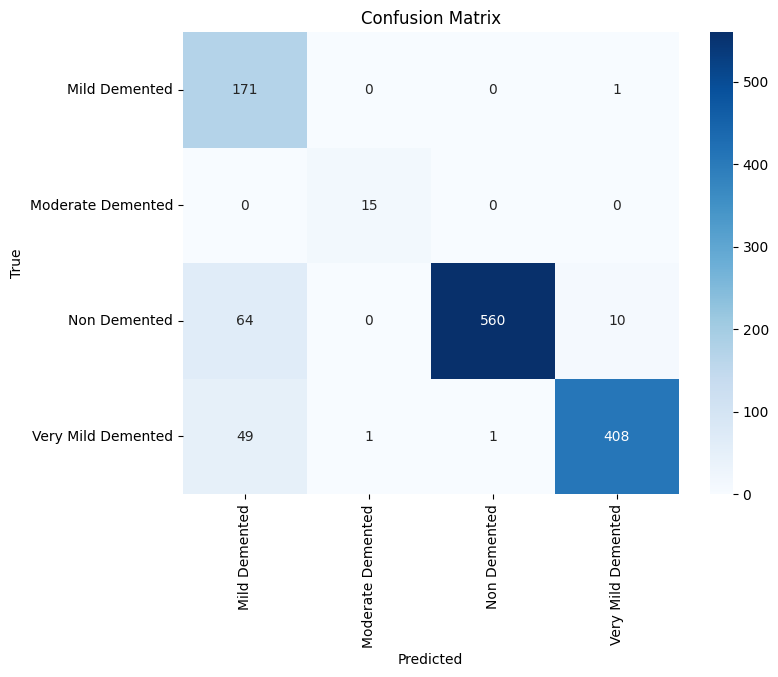

In [ ]:
# Plot Training and Test Loss/Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# F1 Score
f1 = f1_score(epoch_labels, epoch_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Accuracy
print(f"Accuracy: { test_accuracies[-1]:.4f}")

# Confusion Matrix
cm = confusion_matrix(epoch_labels, epoch_preds)

labels = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()